In [1044]:
import sys
import os
import math
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix

In [1045]:
# Append the path for module imports
sys.path.append('../')

# Import custom modules
from modules.dataloader import load_npy_files
from modules.linear_transformation import LinearTransformations
from modules.classifier import DenseLayer, BCELoss, CustomLoss, BCEWithLogits, FocalLoss

In [1046]:
# Define possible configurations for audio feature directories
audio_feature_paths = {
    'logmel': '../misc/audio_fe/logmel_spectrograms',
    'mfcc': '../misc/audio_fe/mfcc_extracted'
}

# Function to get the audio feature path based on the selected configuration
def get_audio_feature_path(config_name):
    if config_name in audio_feature_paths:
        return audio_feature_paths[config_name]
    else:
        raise ValueError(f"Configuration '{config_name}' not found. Available options: logmel, mfcc.")


In [1047]:
### Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

### Audio Feature selection: 'logmel' or 'mfcc'
selected_config = 'logmel'
audio_features_dir = get_audio_feature_path(selected_config)

#### Data Configuration: 8 16 32 64 128
train_batch_size = 32   # Set the batch size for training data
val_batch_size = 16     # Set the batch size for validation data
test_batch_size= 16     # Set the batch size for testing data

#FIXED CONSTANT
max_pad = 197

### Hyperparameters
threshold = 0.5              # for predictions
learning_rate = 1e-5         # For optimizer
cl_dropout_rate = 0.4        # for FinalClassifier
att_dropout_rate = 0.3       # for MutualCrossAttention
num_epochs = 20              # for model training

### Classifier Configuration
isBCELoss = True                          # !!! SET ACCORDINGLY !!!
criterion = BCELoss()
# criterion = BCEWithLogits()
# criterion = CustomLoss(pos_weight=2.94)
# criterion = FocalLoss(alpha=0.25, gamma=2, pos_weight=0.34)

# !!! Choose Classifier !!! False = Dense Layer, True = Final Classifier
isFinalClassifier = False

# ### For cross validation
# num_folds = 5           # Set the number of folds for cross-validation
# batch_size = 32         # Set the batch size for cross-validation


Device: cpu


In [1048]:
class FinalClassifier(nn.Module):
    def __init__(self, input_size, dropout_rate=0.5):
        super(FinalClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)  # From 2304 to 2048
        self.fc2 = nn.Linear(1024, 512)        # From 2048 to 1024
        # self.fc3 = nn.Linear(1024, 512)         # Optional 512 or 768

        self.dropout = nn.Dropout(dropout_rate)
        self.dense = nn.Linear(512, 1)          # Final output layer
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # x = self.fc3(x)
        # x = self.relu(x)

        x = self.dense(x)
        if isBCELoss:
            x = self.sigmoid(x)
        return x


### Data Loading

In [1049]:
class MultimodalDataset(Dataset):
    def __init__(self, id_label_df, text_features, audio_features, video_features):
        self.id_label_df = id_label_df
        
        # Convert feature lists to dictionaries for fast lookup
        self.text_features = {os.path.basename(file).split('.')[0]: tensor for file, tensor in text_features}
        self.audio_features = {os.path.basename(file).split('_')[1].split('.')[0]: tensor for file, tensor in audio_features}
        self.video_features = {os.path.basename(file).split('_')[0]: tensor for file, tensor in video_features}

        # List to store missing files
        self.missing_files = []

        # Filter out entries with missing files
        self.valid_files = self._filter_valid_files()

    def _filter_valid_files(self):
        valid_indices = []
        missing_files = []

        for idx in range(len(self.id_label_df)):
            imdbid = self.id_label_df.iloc[idx]['IMDBid']

            # Check if the IMDBid exists in each modality's features
            if imdbid in self.text_features and imdbid in self.audio_features and imdbid in self.video_features:
                valid_indices.append(idx)
            else:
                missing_files.append({'IMDBid': imdbid})

        # Filter id_label_df to only include valid rows
        self.id_label_df = self.id_label_df.iloc[valid_indices].reset_index(drop=True)
        self.missing_files = missing_files
        
        # Update valid_indices to reflect the new indices after resetting
        valid_indices = list(range(len(self.id_label_df)))

        # Return valid indices
        return valid_indices

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):
        # Get the original index from the filtered valid files
        original_idx = self.valid_files[idx]
        imdbid = self.id_label_df.iloc[original_idx]['IMDBid']
        label = self.id_label_df.iloc[original_idx]['Label']

        # Retrieve data from the loaded features
        text_data = self.text_features.get(imdbid, torch.zeros((1024,)))
        audio_data = self.audio_features.get(imdbid, torch.zeros((1, 197, 768)))
        video_data = self.video_features.get(imdbid, torch.zeros((95, 768)))
        
        # Define label mapping
        label_map = {'red': 1, 'green': 0} 
        
        # Convert labels to tensor using label_map
        try:
            label_data = torch.tensor([label_map[label]], dtype=torch.float32)
        except KeyError as e:
            print(f"Error: Label '{e}' not found in label_map.")
            raise

        return imdbid, text_data, audio_data, video_data, label_data


In [1050]:
def collate_fn(batch):
    # Unpack batch elements
    imdbids, text_data, audio_data, video_data, label_data = zip(*batch)

    # Convert lists to tensors
    text_data = torch.stack(text_data)
    audio_data = torch.stack(audio_data)

    # Padding for video data
    # Determine maximum length of video sequences in the batch
    video_lengths = [v.size(0) for v in video_data]
    max_length = max(video_lengths)

    # Pad video sequences to the maximum length
    video_data_padded = torch.stack([
        F.pad(v, (0, 0, 0, max_length - v.size(0)), "constant", 0)
        for v in video_data
    ])

    # Convert labels to tensor and ensure the shape [batch_size, 1]
    label_data = torch.stack(label_data)  # Convert list of tensors to a single tensor

    return imdbids, text_data, audio_data, video_data_padded, label_data


In [1051]:
def filter_video_features(video_features, lower_bound=35, upper_bound=197):
    # Assuming video_features is a list of tuples where the second element is the numpy array
    filtered_video_features = [v for v in video_features if lower_bound <= v[1].shape[0] <= upper_bound]
    return filtered_video_features


In [1052]:
# Load the labels DataFrame
id_label_df = pd.read_excel('../misc/MM-Trailer_dataset.xlsx')

# Define the directories
text_features_dir = '../misc/textStream_BERT/feature_vectors'
audio_features_dir = '../misc/audio_fe/logmel_spectrograms'
video_features_dir = '../misc/visualStream_ViT'

# Load the feature vectors from each directory
text_features = load_npy_files(text_features_dir)
audio_features = load_npy_files(audio_features_dir)
video_features = load_npy_files(video_features_dir)

video_features = filter_video_features(video_features)

print(f"Number of text feature vectors loaded: {len(text_features)}")
print(f"Number of audio feature vectors loaded: {len(audio_features)}")
print(f"Number of video feature vectors loaded: {len(video_features)}")

# Drop unnecessary columns
id_label_df = id_label_df.drop(columns=['Movie Title', 'URL'])

full_dataset = MultimodalDataset(id_label_df, text_features, audio_features, video_features)

# perform train-test split on the filtered DataFrame
train_df, val_test_df = train_test_split(
    full_dataset.id_label_df, test_size=0.3, random_state=42, stratify=full_dataset.id_label_df['Label'])

# Further splitting remaining set into validation and test sets
val_df, test_df = train_test_split(
    val_test_df, test_size=0.5, random_state=42, stratify=val_test_df['Label'])

print("train_df shape:", train_df.shape)
print("val_df shape:", val_df.shape)
print("test_df shape:", test_df.shape)

print("Train label distribution:", train_df['Label'].value_counts())
print("Validation label distribution:", val_df['Label'].value_counts())
print("Test label distribution:", test_df['Label'].value_counts())

print("-" * 40)

# create datasets based on these splits
train_dataset = MultimodalDataset(train_df, text_features, audio_features, video_features)
val_dataset = MultimodalDataset(val_df, text_features, audio_features, video_features)
test_dataset = MultimodalDataset(test_df, text_features, audio_features, video_features)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42))
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42))
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42))

# Function to calculate and print the size of each DataLoader
def print_dataloader_sizes(dataloader, name):
    total_samples = len(dataloader.dataset)  # Get the size of the dataset
    num_batches = len(dataloader)  # Get the number of batches
    print(f"{name} DataLoader: Total Samples = {total_samples}, Number of Batches = {num_batches}")

# Print sizes of each DataLoader
print_dataloader_sizes(train_dataloader, "Train")
print_dataloader_sizes(val_dataloader, "Validation")
print_dataloader_sizes(test_dataloader, "Test")

Number of text feature vectors loaded: 1353
Number of audio feature vectors loaded: 1353
Number of video feature vectors loaded: 1325
train_df shape: (927, 2)
val_df shape: (199, 2)
test_df shape: (199, 2)
Train label distribution: Label
green    693
red      234
Name: count, dtype: int64
Validation label distribution: Label
green    149
red       50
Name: count, dtype: int64
Test label distribution: Label
green    149
red       50
Name: count, dtype: int64
----------------------------------------
Train DataLoader: Total Samples = 927, Number of Batches = 29
Validation DataLoader: Total Samples = 199, Number of Batches = 13
Test DataLoader: Total Samples = 199, Number of Batches = 13


In [1053]:
def pad_features(features, max_pad=197):
    # Pad or trim the sequence dimension to `max_pad`
    if features.size(1) < max_pad:
        # Pad to the right along the sequence dimension
        features = F.pad(features, (0, 0, 0, max_pad - features.size(1)))
    else:
        # Trim if the sequence is longer than `max_pad`
        features = features[:, :max_pad, :]
    return features

In [1054]:
class MutualCrossAttention(nn.Module):
    def __init__(self, dropout):
        super(MutualCrossAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(768)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, x1, x2):
        # Move x1 and x2 to the correct device
        x1, x2 = x1.to(self.device), x2.to(self.device)

        # Ensure inputs are 3D
        if x1.dim() == 2:
            x1 = x1.unsqueeze(0)
        if x2.dim() == 2:
            x2 = x2.unsqueeze(0)

        # Assign x1 and x2 to query and key
        query = x1
        key = x2
        d = query.shape[-1]

        # Basic attention mechanism formula to get intermediate output A
        scores = torch.bmm(query, key.transpose(1, 2)) / math.sqrt(d)
        output_A = torch.bmm(self.dropout(F.softmax(scores, dim=-1)), x2)

        # Make the summation of the two intermediate outputs
        output = output_A
        
        return output

In [1055]:
def HadamardProduct(tensor1, tensor2):
    # Ensure both tensors have the same shape
    if tensor1.shape != tensor2.shape:
        raise ValueError("Tensors must have the same shape for Hadamard product.")
    
    # Compute the Hadamard product
    return tensor1 * tensor2

In [1056]:
class EmbracementLayer(nn.Module):
    def __init__(self, d_in, d_out):
        super(EmbracementLayer, self).__init__()
        self.fc = nn.Linear(d_in, d_out)
        self.norm = nn.LayerNorm(d_out)
        self.activation = nn.ReLU()

    def forward(self, video_features, audio_features, text_features):
        # Concatenate features along the last dimension
        combined_features = torch.cat([video_features, audio_features, text_features], dim=-1)
        
        # Apply linear transformation
        transformed_features = self.fc(combined_features)
        
        # Apply normalization and activation
        norm_features = self.norm(transformed_features)
        output = self.activation(norm_features)
        
        return output

In [1057]:
def get_optimizer(parameters, lr=learning_rate):
    # Create an optimizer, for example, Adam
    return optim.Adam(parameters, lr=lr)

In [1058]:
def train_model(dense_layer, dataloader, criterion, optimizer, device, output_dir='results/', output_filename='train_predictions.csv'):
    dense_layer.train()  # Set the model to training mode
    total_loss = 0.0

    os.makedirs(output_dir, exist_ok=True)

    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device)

    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    accuracy_metric.reset()

    results = []

    print("-" * 20, "Train", "-" * 20)


    for batch in dataloader:
        # Assuming batch is a tuple (fused_features, targets)
        fused_features, targets = batch

        # Move tensors to the specified device
        fused_features = fused_features.to(device)
        targets = targets.to(device)

        # Pass the fused features through the dense layer
        predictions = dense_layer(fused_features).squeeze()  # Ensure correct shape

        # Compute loss
        loss = criterion(predictions, targets)
        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if not isBCELoss:
            predictions = torch.sigmoid(predictions)
        
        preds = (predictions >= threshold).float()

        precision_metric.update(preds.long(), targets.long())
        recall_metric.update(preds.long(), targets.long())
        f1_metric.update(preds.long(), targets.long())
        accuracy_metric.update(preds.long(), targets.long()) 
        

    # Compute average precision, recall, F1 score, and accuracy
    train_precision = precision_metric.compute().item()
    train_recall = recall_metric.compute().item()
    train_f1_score = f1_metric.compute().item()
    train_accuracy = accuracy_metric.compute().item()  # Compute accuracy
    
    train_average_loss = total_loss / len(dataloader)

    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Train Precision: {train_precision:.4f}")
    print(f"Train Recall: {train_recall:.4f}")
    print(f"Train F1 Score: {train_f1_score:.4f}")
    print(f"Train Loss: {train_average_loss:.4f}")
    
    # Create DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False, header=True)

    return train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score


In [1059]:
def evaluate_model(dense_layer, dataloader, criterion, device, output_dir='results/', output_filename='val_predictions.csv'):
    dense_layer.eval()
    total_loss = 0

    os.makedirs(output_dir, exist_ok=True)

    # Initialize metrics for binary classification
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device)

    # Reset metrics at the start of training
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    accuracy_metric.reset()
    
    all_predictions = []
    all_targets = []
    
    # List to collect results for CSV
    results = []
    
    print("-" * 20, "Eval", "-" * 20) 
    
    with torch.no_grad():
        for fused_features, targets in dataloader:
            fused_features, targets = (
                fused_features.to(device),  # Use fused features directly
                targets.to(device).squeeze()
            )

            # Pass the fused features through the dense layer
            predictions = dense_layer(fused_features).squeeze()  
            
            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()

            if not isBCELoss:
                predictions = torch.sigmoid(predictions)

            # Apply threshold to get binary predictions
            preds = (predictions > 0.5).float()

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            # Update the precision, recall, and F1 score metrics
            precision_metric.update(preds.long(), targets.long())
            recall_metric.update(preds.long(), targets.long())
            f1_metric.update(preds.long(), targets.long())
            accuracy_metric.update(preds.long(), targets.long()) 

    # Compute average precision, recall, F1 score, and accuracy
    val_precision = precision_metric.compute().item()
    val_recall = recall_metric.compute().item()
    val_f1_score = f1_metric.compute().item()
    val_accuracy = accuracy_metric.compute().item() 
    
    # Calculate confusion matrix
    val_conf_matrix = confusion_matrix(all_targets, np.round(all_predictions))

    val_average_loss = total_loss / len(dataloader)
    print(f"Eval Accuracy: {val_accuracy:.4f}")
    print(f"Eval Precision: {val_precision:.4f}")
    print(f"Eval Recall: {val_recall:.4f}")
    print(f"Eval F1 Score: {val_f1_score:.4f}")
    print(f"Eval Loss: {val_average_loss:.4f}")
    
    # Create DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False, header=True)
    
    return val_average_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_conf_matrix


In [1060]:
def test_model(dense_layer, dataloader, criterion, device, output_dir='results/', output_filename='test_predictions.csv'):
    dense_layer.eval()
    total_loss = 0
    
    # Initialize metrics
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device)

    all_predictions = []
    all_targets = []
    results = []

    print("-" * 20, "Test", "-" * 20)

    with torch.no_grad():
        for fused_features, targets in dataloader:
            fused_features = fused_features.to(device)
            targets = targets.to(device).squeeze()

            predictions = dense_layer(fused_features).squeeze()
            loss = criterion(predictions, targets)
            total_loss += loss.item()

            if not isBCELoss:
                predictions = torch.sigmoid(predictions)

            # Round predictions for binary classification
            preds = (predictions > threshold).float()
            
            # Store rounded predictions and targets
            all_predictions.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            precision_metric.update(preds.long(), targets.long())
            recall_metric.update(preds.long(), targets.long())
            f1_metric.update(preds.long(), targets.long())
            accuracy_metric.update(preds.long(), targets.long())

    # Calculate metrics
    test_precision = precision_metric.compute().item()
    test_recall = recall_metric.compute().item()
    test_f1_score = f1_metric.compute().item()
    test_accuracy = accuracy_metric.compute().item()
    
    # Create confusion matrix with rounded predictions
    test_conf_matrix = confusion_matrix(all_targets, all_predictions)

    test_average_loss = total_loss / len(dataloader)
    
    # Print metrics
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1 Score: {test_f1_score:.4f}")
    print(f"Test Loss: {test_average_loss:.4f}")
    
    # Save results
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False)

    return test_average_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_conf_matrix

In [1061]:
def PairCrossAttention(modalityAlpha, modalityBeta, dropout=att_dropout_rate):
    mutual_cross_attn = MutualCrossAttention(dropout)
    return mutual_cross_attn(modalityAlpha, modalityBeta)

### Fusion

In [1062]:
# Initialize list to store fused features for each file
fused_features_list = []
labels_list = []
batch_size = 32  # Adjust based on your available memory

for batch_start in range(0, len(text_features), batch_size):
    batch_end = min(batch_start + batch_size, len(text_features))
    batch_text_features = text_features[batch_start:batch_end]
    batch_audio_features = audio_features[batch_start:batch_end]
    batch_video_features = video_features[batch_start:batch_end]
    print(f"Batch: {batch_start}")
    # Loop through all the files in the dataset
    for i in range(len(batch_text_features)):
        # Extract features for the current file
        text_file_name, text_feature = text_features[i]  # Renamed to avoid shadowing
        audio_file_name, audio_feature = audio_features[i]  # Renamed to avoid shadowing
        video_file_name, video_feature = video_features[i]  # Renamed to avoid shadowing

        # print(f"Processing file {text_file_name}")

        # Check if any features are missing
        if text_feature is None or audio_feature is None or video_feature is None:
            print(f"Skipping file {i + 1}/{len(text_features)}: Missing features for {text_file_name}, {audio_file_name}, {video_file_name}")
            continue  # Skip to the next iteration

        # print("Text file name:", text_file_name)
        # print("Audio file name:", audio_file_name)
        # print("Video file name:", video_file_name)

        print("Text features shape:", text_feature.shape)
        print("Audio features shape:", audio_feature.shape)
        print("Video features shape:", video_feature.shape)

        # Transform text features
        linear_transform_text = LinearTransformations(text_feature.shape[-1], 768)
        text_feature = linear_transform_text(text_feature.unsqueeze(0))  # [1, 768]

        # Transform audio features (use last sequence)
        audio_feature = audio_feature[:, -1, :]  # Shape: [1, 768]

        # Pad video features
        video_feature = video_feature.unsqueeze(0)  # [1, 197, 768]
        video_feature = pad_features(video_feature)
        video_feature = video_feature.squeeze(0)  # [1, 197, 768]
        
        print("After transformation:")
        print("text_features shape:", text_feature.shape)
        print("audio_features shape:", audio_feature.shape)
        print("video_features shape:", video_feature.shape, '\n')

        with torch.no_grad():
            
            text_video = PairCrossAttention(text_feature, video_feature)
            text_audio = PairCrossAttention(text_feature, audio_feature)
            audio_video = PairCrossAttention(audio_feature, video_feature)

            text_combined = HadamardProduct(text_video, text_audio)
            audio_combined = HadamardProduct(audio_video, text_audio)
            video_combined = HadamardProduct(text_video, audio_video)

            print("Text-Video Shape:", text_video.shape)
            print("Text-Audio Shape:", text_audio.shape)
            print("Audio-Video Shape:", audio_video.shape, '\n')

            print("Text-Combined Shape:", text_combined.shape)
            print("Audio-Combined Shape:", audio_combined.shape)
            print("Video-Combined Shape:", video_combined.shape, '\n')

            # Calculate d_in
            d_in = video_combined.shape[-1] + audio_combined.shape[-1] + text_combined.shape[-1]
            embracement_layer = EmbracementLayer(d_in, d_in)

            # Process features
            fused_features = embracement_layer(video_combined[-1], audio_combined[-1], text_combined[-1])            
            print('\n',"Fused Features Shape:", fused_features.shape, '\n')

            print("TV and AV: ", text_video.shape, audio_video.shape, '\n')

            print("TA: ", text_audio.shape, '\n')

            # Append the fused features and the corresponding label to the lists
            fused_features_list.append(fused_features)
            label = id_label_df.iloc[i]['Label']  # Assuming you have a column 'Label'
            labels_list.append(label)

        del text_feature, audio_feature, video_feature
        del text_video, text_audio, audio_video
        
# Stack all fused features into a tensor for training
fused_features_tensor = torch.stack(fused_features_list)

# Convert labels to tensor
label_map = {'red': 1, 'green': 0}  # Adjust if your labels differ
labels_tensor = torch.tensor([label_map[label] for label in labels_list], dtype=torch.float32)

Batch: 0
Text features shape: torch.Size([1024])
Audio features shape: torch.Size([1, 197, 768])
Video features shape: torch.Size([79, 768])
After transformation:
text_features shape: torch.Size([1, 768])
audio_features shape: torch.Size([1, 768])
video_features shape: torch.Size([197, 768]) 

Text-Video Shape: torch.Size([1, 1, 768])
Text-Audio Shape: torch.Size([1, 1, 768])
Audio-Video Shape: torch.Size([1, 1, 768]) 

Text-Combined Shape: torch.Size([1, 1, 768])
Audio-Combined Shape: torch.Size([1, 1, 768])
Video-Combined Shape: torch.Size([1, 1, 768]) 


 Fused Features Shape: torch.Size([1, 2304]) 

TV and AV:  torch.Size([1, 1, 768]) torch.Size([1, 1, 768]) 

TA:  torch.Size([1, 1, 768]) 

Text features shape: torch.Size([1024])
Audio features shape: torch.Size([1, 197, 768])
Video features shape: torch.Size([129, 768])
After transformation:
text_features shape: torch.Size([1, 768])
audio_features shape: torch.Size([1, 768])
video_features shape: torch.Size([197, 768]) 

Text-Vide

In [1063]:
# # Splitting data for training, validation, and testing
# train_df, val_test_df, train_labels, val_test_labels = train_test_split(
#     fused_features_tensor, labels_tensor, test_size=0.3, random_state=42, stratify=labels_tensor)

# # Further splitting remaining set into validation and test sets
# val_df, test_df, val_labels, test_labels = train_test_split(
#     val_test_df, val_test_labels, test_size=0.5, random_state=42, stratify=val_test_labels)

# # Create DataLoaders
# train_loader = DataLoader(list(zip(train_df, train_labels)), batch_size=16, shuffle=True)
# val_loader = DataLoader(list(zip(val_df, val_labels)), batch_size=16, shuffle=False)
# test_loader = DataLoader(list(zip(test_df, test_labels)), batch_size=16, shuffle=False)

# print("Train size:", len(train_loader))
# print("Validation size:", len(val_loader))
# print("Test size:", len(test_loader))

In [1065]:
if __name__ == "__main__":
    torch.manual_seed(42)

    # Check for device availability
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    # Input dimension bxased on fused features tensor
    input_dim = fused_features_tensor.shape[-1]

    print("Input Dimension:", input_dim)

    if isFinalClassifier:
        dense_layer = FinalClassifier(input_size=input_dim).to(device)
    else:
        dense_layer = DenseLayer(input_size=input_dim).to(device)  # Initialize and move the dense layer to the correct device

    optimizer = get_optimizer(list(dense_layer.parameters()), learning_rate)  # Pass only the dense layer parameters

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print("-" * 40)
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Ensure you have a dataloader that yields inputs and targets
        train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score = train_model(dense_layer=dense_layer, dataloader=train_loader, criterion=criterion, optimizer=optimizer, device=device)
        train_losses.append(train_average_loss)  # Store training loss

        # Validate step
        eval_average_loss, eval_accuracy, eval_precision, eval_recall, eval_f1_score, eval_conf_matrix = evaluate_model(dense_layer=dense_layer, dataloader=val_loader, criterion=criterion, device=device)
        val_losses.append(eval_average_loss)  # Store validation loss

        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        print("-" * 30)
    
    # Testing the model
    print("-"*40)
    print("Testing the model on the test set...")
    test_average_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_conf_matrix = test_model(dense_layer=dense_layer, dataloader=test_loader, criterion=criterion, device=device)

    # Summary of metrics
    metrics_summary = {
        "Train Accuracy": [train_accuracy],
        "Validation Accuracy": [eval_accuracy],
        "Test Accuracy": [test_accuracy],
        "Train Precision": [train_precision],
        "Validation Precision": [eval_precision],
        "Test Precision": [test_precision],
        "Train Recall": [train_recall],
        "Validation Recall": [eval_recall],
        "Test Recall": [test_recall],
        "Train F1 Score": [train_f1_score],
        "Validation F1 Score": [eval_f1_score],
        "Test F1 Score": [test_f1_score],
        "Train Loss": [train_average_loss],
        "Validation Loss": [eval_average_loss],
        "Test Loss": [test_average_loss]
    }
    
    # Create DataFrame
    metrics_df = pd.DataFrame(metrics_summary)


Input Dimension: 2304
----------------------------------------
Epoch 1/20
-------------------- Train --------------------
Train Accuracy: 0.6082
Train Precision: 0.3175
Train Recall: 0.1231
Train F1 Score: 0.1774
Train Loss: 0.6744
-------------------- Eval --------------------
Eval Accuracy: 0.6158
Eval Precision: 0.3667
Eval Recall: 0.1571
Eval F1 Score: 0.2200
Eval Loss: 0.6531
Training Loss: 0.2013, Validation Loss: 0.7799
------------------------------
----------------------------------------
Epoch 2/20
-------------------- Train --------------------
Train Accuracy: 0.6389
Train Precision: 0.3559
Train Recall: 0.0646
Train F1 Score: 0.1094
Train Loss: 0.6653
-------------------- Eval --------------------
Eval Accuracy: 0.6601
Eval Precision: 0.5294
Eval Recall: 0.1286
Eval F1 Score: 0.2069
Eval Loss: 0.6479
Training Loss: 0.2013, Validation Loss: 0.7799
------------------------------
----------------------------------------
Epoch 3/20
-------------------- Train -------------------

In [ ]:
# Function to plot training and validation loss
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(val_losses, label='Validation Loss', color='orange', marker='x')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

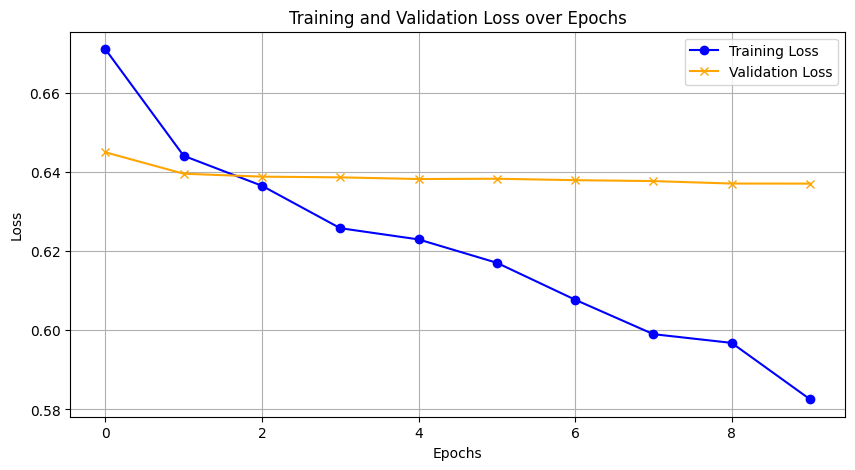

In [ ]:
plot_losses(train_losses, val_losses)

In [ ]:
def plot_confusion_matrix(conf_matrix, class_names=['Negative', 'Positive']):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

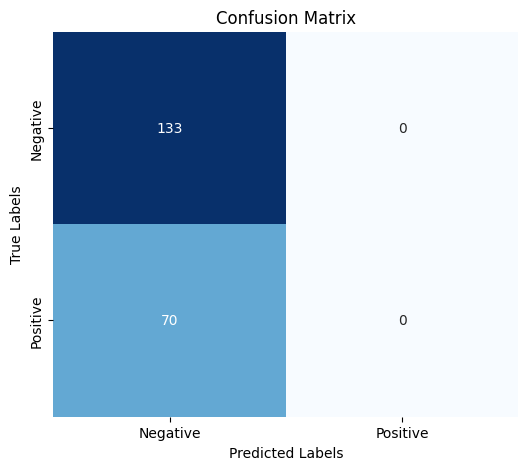

In [ ]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(test_conf_matrix)

In [ ]:
# Print sizes of each DataLoader (FOR CHECKING)
print_dataloader_sizes(train_dataloader, "Train")
print_dataloader_sizes(val_dataloader, "Validation")
print_dataloader_sizes(test_dataloader, "Test")

Train DataLoader: Total Samples = 927, Number of Batches = 29
Validation DataLoader: Total Samples = 199, Number of Batches = 13
Test DataLoader: Total Samples = 199, Number of Batches = 13


In [ ]:
train_df = pd.read_csv('results/train_predictions.csv')
train_df

EmptyDataError: No columns to parse from file

In [ ]:
eval_df = pd.read_csv('results/val_predictions.csv')
eval_df

In [ ]:
test_df = pd.read_csv('results/test_predictions.csv')
test_df